In [1]:
import scipy
from scipy.interpolate import CubicHermiteSpline, PPoly, interp1d
from scipy.integrate import solve_ivp, ode, odeint
import jax
import pickle
import numpy as np
import matplotlib.pyplot as plt

def dynamics(state, control):
    '''
    implement the function x_dot = f(x,u)
    return the derivative w.r.t. x
    '''
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5  # cart
    # define the name for each state index and action index
    STATE_X, STATE_V, STATE_THETA, STATE_W = 0, 1, 2, 3
    CONTROL_A = 0
    # define boundary
    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2
    # obstacle information
    OBS_W = 4
    _v = state[STATE_V]
    _w = state[STATE_W]
    _theta = state[STATE_THETA]
    _a = control[CONTROL_A]
    mass_term = (M + m)*(I + m * L * L) - \
            m * m * L * L * np.cos(_theta) * np.cos(_theta)

    deriv = np.zeros(4)  # init derivative
    deriv[STATE_X] = _v
    deriv[STATE_THETA] = _w
    mass_term = (1.0 / mass_term)
    deriv[STATE_V] = ((I + m * L * L)* \
        (_a + m * L * _w * _w * np.sin(_theta)) + \
        m * m * L * L * np.cos(_theta) * np.sin(_theta) * g) * mass_term
    deriv[STATE_W] = ((-m * L * np.cos(_theta)) * \
        (_a + m * L * _w * _w * np.sin(_theta))+(M + m) * \
        (-m * g * L * np.sin(_theta))) * mass_term
    return deriv

def enforce_bounds(state):
    '''

    check if state satisfies the bound
    apply threshold to velocity and angle
    return a new state toward which the bound has been enforced
    '''
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5  # cart
    # define the name for each state index and action index
    STATE_X, STATE_V, STATE_THETA, STATE_W = 0, 1, 2, 3
    CONTROL_A = 0
    # define boundary
    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2
    # obstacle information
    OBS_W = 4
    new_state = np.array(state)
    if state[STATE_V] < MIN_V:
        new_state[STATE_V] = MIN_V
    elif state[STATE_V] > MAX_V:
        new_state[STATE_V] = MAX_V

    if state[STATE_THETA] < -np.pi:
        new_state[STATE_THETA] += 2*np.pi
    elif state[STATE_THETA] > np.pi:
        new_state[STATE_THETA] -= 2*np.pi

    if state[STATE_W] < MIN_W:
        new_state[STATE_W] = MIN_W
    elif state[STATE_W] > MAX_W:
        new_state[STATE_W] = MAX_W
    return new_state



def jax_dynamics(state, control):
    '''
    implement the function x_dot = f(x,u)
    return the derivative w.r.t. x
    '''
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5  # cart
    # define the name for each state index and action index
    STATE_X, STATE_V, STATE_THETA, STATE_W = 0, 1, 2, 3
    CONTROL_A = 0
    # define boundary
    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2
    # obstacle information
    OBS_W = 4
    _v = state[STATE_V]
    _w = state[STATE_W]
    _theta = state[STATE_THETA]
    _a = control[CONTROL_A]
    mass_term = (M + m)*(I + m * L * L) - \
            m * m * L * L * jax.numpy.cos(_theta) * jax.numpy.cos(_theta)

    deriv = np.zeros(4)  # init derivative
    deriv[STATE_X] = _v
    deriv[STATE_THETA] = _w
    mass_term = (1.0 / mass_term)
    deriv[STATE_V] = ((I + m * L * L)* \
        (_a + m * L * _w * _w * jax.numpy.sin(_theta)) + \
        m * m * L * L * jax.numpy.cos(_theta) * jax.numpy.sin(_theta) * g) * mass_term
    deriv[STATE_W] = ((-m * L * jax.numpy.cos(_theta)) * \
        (_a + m * L * _w * _w * jax.numpy.sin(_theta))+(M + m) * \
        (-m * g * L * jax.numpy.sin(_theta))) * mass_term
    return deriv


def true_linear(x, u):
    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi
    MIN_W, MAX_W = -7., 7

    MIN_TORQUE, MAX_TORQUE = -1., 1.

    LENGTH = 1.
    MASS = 1.
    DAMPING = .05
    gravity_coeff = MASS*9.81*LENGTH*0.5
    integration_coeff = 3. / (MASS*LENGTH*LENGTH)
    A = np.zeros((2,2))
    A[0,0] = 0
    A[0,1] = 1.
    A[1,0] = integration_coeff*gravity_coeff*np.sin(x[0])
    A[1,1] = -integration_coeff*DAMPING
    B = np.zeros((2,1))
    B[0,0] = 0
    B[1,0] = integration_coeff
    return A,B
 


def jaxfunc(x, u):
    return jax.numpy.asarray(jax_dynamics(x, u))

def linearization(x, u):
    A = jax.jacfwd(jaxfunc, argnums=0)(x, u)
    B = jax.jacfwd(jaxfunc, argnums=1)(x, u)
    return A, B
    

# see if the linearization is working fine
direction = np.random.normal(size=5)
direction = direction / np.linalg.norm(direction)
epsilon = np.linspace(-1, 1, 100)

x = np.array([0.,0.,0.,0.])
u = np.array([0.])
state = np.array([x[0], x[1], x[2], x[3], u[0]])
# linearlize around this point
approx_error = []
for i in range(len(epsilon)):
    new_state = direction * epsilon[i] + state
    new_x = new_state[:4]
    new_u = np.array([new_state[4]])
    true_dx = dynamics(new_x, new_u)
    A, B = linearization(x, u)
    approx_dx = dynamics(x, u) + A @ (new_x - x) + B @ (new_u - u)
    approx_error.append(np.linalg.norm(approx_dx - true_dx))
plt.plot(epsilon, approx_error)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# plotting the lyapunov verification region
from python_lyapunov_test import *
# read the data obtained from sparse_rrt

def dynamics(state, control):
    '''
    implement the function x_dot = f(x,u)
    return the derivative w.r.t. x
    '''
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5  # cart
    # define the name for each state index and action index
    STATE_X, STATE_V, STATE_THETA, STATE_W = 0, 1, 2, 3
    CONTROL_A = 0
    # define boundary
    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2
    # obstacle information
    OBS_W = 4
    _v = state[STATE_V]
    _w = state[STATE_W]
    _theta = state[STATE_THETA]
    _a = control[CONTROL_A]
    mass_term = (M + m)*(I + m * L * L) - \
            m * m * L * L * np.cos(_theta) * np.cos(_theta)

    deriv = np.zeros(4)  # init derivative
    deriv[STATE_X] = _v
    deriv[STATE_THETA] = _w
    mass_term = (1.0 / mass_term)
    # normalize: added (1/max_X) term
    #deriv[STATE_V] = (1/MAX_X)*((I + m * L * L)* \
    deriv[STATE_V] = ((I + m * L * L)* \
        (_a + m * L * _w * _w * np.sin(_theta)) + \
        m * m * L * L * np.cos(_theta) * np.sin(_theta) * g) * mass_term
    deriv[STATE_W] = ((-m * L * np.cos(_theta)) * \
        (_a + m * L * _w * _w * np.sin(_theta))+(M + m) * \
        (-m * g * L * np.sin(_theta))) * mass_term
    return deriv

def enforce_bounds(state):
    '''

    check if state satisfies the bound
    apply threshold to velocity and angle
    return a new state toward which the bound has been enforced
    '''
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5  # cart
    # define the name for each state index and action index
    STATE_X, STATE_V, STATE_THETA, STATE_W = 0, 1, 2, 3
    CONTROL_A = 0
    # define boundary
    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2
    # obstacle information
    OBS_W = 4
    new_state = np.array(state)
    """
    if state[STATE_V] < MIN_V/30.:
        new_state[STATE_V] = MIN_V/30.
    elif state[STATE_V] > MAX_V/30.:
        new_state[STATE_V] = MAX_V/30.
    """
    if state[STATE_V] < MIN_V:
        new_state[STATE_V] = MIN_V
    elif state[STATE_V] > MAX_V:
        new_state[STATE_V] = MAX_V

    if state[STATE_THETA] < -np.pi:
        new_state[STATE_THETA] += 2*np.pi
    elif state[STATE_THETA] > np.pi:
        new_state[STATE_THETA] -= 2*np.pi

    if state[STATE_W] < MIN_W:
        new_state[STATE_W] = MIN_W
    elif state[STATE_W] > MAX_W:
        new_state[STATE_W] = MAX_W
    return new_state



def jax_dynamics(state, control):
    '''
    implement the function x_dot = f(x,u)
    return the derivative w.r.t. x
    '''
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5  # cart
    # define the name for each state index and action index
    STATE_X, STATE_V, STATE_THETA, STATE_W = 0, 1, 2, 3
    CONTROL_A = 0
    # define boundary
    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2
    # obstacle information
    OBS_W = 4
    _v = state[STATE_V]
    _w = state[STATE_W]
    _theta = state[STATE_THETA]
    _a = control[CONTROL_A]
    mass_term = (M + m)*(I + m * L * L) - \
            m * m * L * L * jax.numpy.cos(_theta) * jax.numpy.cos(_theta)

    deriv = [0,0,0,0]  # init derivative
    deriv[STATE_X] = _v
    deriv[STATE_THETA] = _w
    mass_term = (1.0 / mass_term)
    # normalize (added 1/max_X term)
    #deriv[STATE_V] = (1/MAX_X)*((I + m * L * L)* \
    deriv[STATE_V] = ((I + m * L * L)* \
        (_a + m * L * _w * _w * jax.numpy.sin(_theta)) + \
        m * m * L * L * jax.numpy.cos(_theta) * jax.numpy.sin(_theta) * g) * mass_term
    deriv[STATE_W] = ((-m * L * jax.numpy.cos(_theta)) * \
        (_a + m * L * _w * _w * jax.numpy.sin(_theta))+(M + m) * \
        (-m * g * L * jax.numpy.sin(_theta))) * mass_term
    return jax.numpy.asarray(deriv)


In [3]:




f = open('../../data/cartpole/0/path_11.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
x = p.load()
#for i in range(len(x)):
#    x[i][0] = x[i][0] / 30.
#    x[i][1] = x[i][1] / 30.  # normalize state and velocity
f = open('../../data/cartpole/0/control_11.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
u = p.load()
u = u.reshape(len(u),1)
f = open('../../data/cartpole/0/cost_11.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
dt = p.load()
"""
# cartpole
f = open('../../data/cartpole/0/path_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
x = p.load()
f = open('../../data/cartpole/0/control_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
u = p.load()
u = u.reshape(len(u),1)
f = open('../../data/cartpole/0/cost_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
dt = p.load()
goal = x[-1]
#goal = sg[-1]
"""


new_x = []
new_u = []
new_dt = []
new_x0 = x[0]
new_x.append(new_x0)
# what if we only look at the first segment

x0 = x[0]
xT = x[-1]
print('previous xT:')
print(xT)

for i in range(len(dt)):
    for j in range(int(dt[i]/0.02)):
        new_x0 = new_x0 + 0.02*dynamics(new_x0, u[i])
        new_x0 = enforce_bounds(new_x0)
        #new_x.append(new_x0)
        #new_u.append(u[i])
        #new_dt.append(0.02)
    new_x.append(new_x0)
    new_u.append(u[i])
    new_dt.append(dt[i])
x = new_x
u = new_u
dt = new_dt
goal = x[-1]

time_knot = np.cumsum(new_dt)
time_knot = np.insert(time_knot, 0, 0.)
print(time_knot)
# obtain a lqr for end position
#A = jax.jacfwd(jaxfunc, argnums=0)(xtraj(time_knot[-1]), utraj(time_knot[-1]))
#B = jax.jacfwd(jaxfunc, argnums=1)(xtraj(time_knot[-1]), utraj(time_knot[-1]))

controller, xtraj, utraj, S = tvlqr(x, u, dt, dynamics, jax_dynamics)


previous xT:
[-18.06641918  -0.10798749  -1.87543859  -0.06619474]
[ 0.     0.146  0.48   0.976  1.218  1.77   2.588  3.612  4.766  5.964
  7.118  8.142  8.96   9.512  9.754  9.948 10.128 10.538]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]


In [4]:
#print(x)
#x = np.array(x)

#indices = np.arange(0, len(time_knot), 10)
#time_knot = time_knot[indices]
#print(time_knot)

In [5]:
#time_knot = np.append(time_knot, np.sum(new_dt))
# including the end index
#print(time_knot)

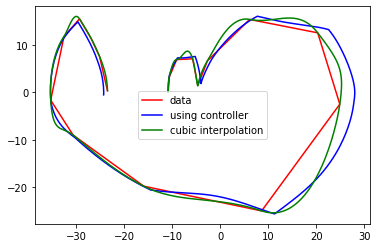

In [6]:
x = np.array(x)
plt.plot(x[:,0], x[:,1], 'r', label='data')

#num = 200
num = np.sum(dt) / 0.02
time_span = np.linspace(0, np.sum(dt), num+1)
delta_t = time_span[-1] / num
actual_x = np.array(x0)
xs = []
xs.append(actual_x)
real_xs = []
# plot data
for i in range(len(time_span)):
    u = controller(time_span[i], actual_x)
    #print('current state:')
    #print(x)
    #print('tracked traj:')
    #print(x_traj(time_span[i]))
    xdot = dynamics(actual_x, u)
    actual_x = actual_x + xdot * delta_t
    xs.append(actual_x)
    real_xs.append(xtraj(time_span[i]))
    actual_x = enforce_bounds(actual_x)
xs = np.array(xs)
real_xs = np.array(real_xs)
#print(xs)
#print(real_xs)
plt.plot(xs[:,0], xs[:,1], 'b', label='using controller')
plt.plot(real_xs[:,0], real_xs[:,1], 'g', label='cubic interpolation')
plt.legend()

In [7]:
xG = np.array(goal)
uG = np.zeros((1))
uG = np.array([0.])
#uG = stable_u(xG)
print(dynamics(xG, uG))
A = jax.jacfwd(jax_dynamics, argnums=0)(xG, uG)
B = jax.jacfwd(jax_dynamics, argnums=1)(xG, uG)

A = np.asarray(A)
B = np.asarray(B)
Q = np.identity(len(x[0]))
R = np.identity(len(uG))
K, lqr_S, E = control.lqr(A, B, Q, R)

#print(dynamics(xtraj(time_knot[-1]), utraj(time_knot[-1])))
lqr_rho = sample_ti_verify(xG, uG, lqr_S, K, dynamics, numSample=1000)
# create a funnel that guides
upper_rho = lqr_rho
upper_x = xG
upper_S = np.identity(len(lqr_S))
lqr_S = np.identity(len(lqr_S))
# in cartpole problem, we may not be able to stablize around the endpoint, set it to a large value
upper_rho = 1.5
tvlqr_rhos = []
print(len(time_knot))

for i in range(len(time_knot)-1,0,-1):
    print('knot %d' % (i))
    t0 = time_knot[i-1]
    t1 = time_knot[i]
    x0 = xtraj(t0)
    u0 = utraj(t0)
    x1 = xtraj(t1)
    u1 = utraj(t1)
    A0 = jax.jacfwd(jax_dynamics, argnums=0)(x0, u0)
    B0 = jax.jacfwd(jax_dynamics, argnums=1)(x0, u0)
    A1 = jax.jacfwd(jax_dynamics, argnums=0)(x1, u1)
    B1 = jax.jacfwd(jax_dynamics, argnums=1)(x1, u1)
    A0 = np.asarray(A0)
    B0 = np.asarray(B0)
    A1 = np.asarray(A1)
    B1 = np.asarray(B1)

    S0 = S(t0).reshape(len(x0),len(x0))
    S1 = S(t1).reshape(len(x0),len(x0))
    
    #rho0, rhodot0, rho1, rhodot1 = sample_tv_verify_cubic_doubleside(t0, t1, upper_x, upper_S, upper_rho, S0, S1, A0, A1, B0, B1, R, Q, x0, x1, u0, u1, dynamics, numSample=1000)
    #rho0, rhodot0, rho1, rhodot1 = sample_tv_verify_cubic_doubleside_num(t0, t1, upper_x, upper_S, upper_rho, S, R, Q, x=xtraj, u=utraj, func=dynamics, jax_func=jax_dynamics, numSample=1000)
    #rho0, rhodot0, rho1, rhodot1 = sample_tv_verify_cubic_num(t0, t1, upper_x, upper_S, upper_rho, S0, S1, A0, A1, B0, B1, R, Q, x0, x1, u0, u1, dynamics, numSample=1000)
    #rho0, rho1 = sample_tv_verify_num(t0, t1, upper_x, upper_S, upper_rho, S0, S1, A0, A1, B0, B1, R, Q, x0, x1, u0, u1, dynamics, numSample=1000)
    rho0, rho1 = sample_tv_verify_doubleside(t0, t1, upper_x, upper_S, upper_rho, S0, S1, A0, A1, B0, B1, R, Q, x0, x1, u0, u1, dynamics, numSample=1000)

    upper_rho = rho0
    upper_x = x0
    upper_S = S0
    #tvlqr_rhos.append([rho0, rhodot0, rho1, rhodot1, t0, t1])
    tvlqr_rhos.append([rho0, rho1, t0, t1])
    
    


[ 0.33960499 -0.3924632   0.64251638  2.97145682]
rho: 
1e-06
18
knot 17
rho0:
0.7500000000000004
rho1:
1.44000004
knot 16
rho0:
0.4500000000000005
rho1:
0.6750001000000004
knot 15
rho0:
0.3375000000000004
rho1:
0.44100002000000055
knot 14
rho0:
0.2193750000000002
rho1:
0.3307500200000004
knot 13
rho0:
0.021937500000000085
rho1:
0.032907100000000036
knot 12
rho0:
0.02084062500000008
rho1:
0.021718135000000086
knot 11
rho0:
0.01875656250000007
rho1:
0.019590247500000078
knot 10
rho0:
0.017818734375000065
rho1:
0.017818784375000066
knot 9
after stepping up, rho0:
0.017996921718750065
rho0:
0.017818734375000065
rho1:
0.017640557031250066
knot 8
rho0:
0.016927797656250063
rho1:
0.01692784765625006
knot 7
rho0:
0.015235017890625056
rho1:
0.01591218979687506
knot 6
rho0:
0.01371151610156255
rho1:
0.014473316996093803
knot 5
rho0:
0.013025940296484422
rho1:
0.013025990296484422
knot 4
rho0:
0.012374643281660202
rho1:
0.012504942684625044
knot 3
rho0:
0.011755911117577192
rho1:
0.0120034339832

In [8]:
print(time_knot)
print(xtraj(0))
print(x[0])

[ 0.     0.146  0.48   0.976  1.218  1.77   2.588  3.612  4.766  5.964
  7.118  8.142  8.96   9.512  9.754  9.948 10.128 10.538]
[-10.85549272   0.          -0.43466169   0.        ]
[-10.85549272   0.          -0.43466169   0.        ]


10.127999999999998
10.173555555555554
10.21911111111111
10.264666666666665
10.31022222222222
10.355777777777776
10.401333333333332
10.446888888888887
10.492444444444443
10.537999999999998
9.947999999999999
9.967999999999998
9.987999999999998
10.008
10.027999999999999
10.047999999999998
10.067999999999998
10.088
10.107999999999999
10.127999999999998
9.753999999999998
9.775555555555554
9.797111111111109
9.818666666666665
9.84022222222222
9.861777777777776
9.883333333333331
9.904888888888888
9.926444444444442
9.947999999999999
9.511999999999999
9.538888888888888
9.565777777777777
9.592666666666664
9.619555555555554
9.646444444444443
9.673333333333332
9.70022222222222
9.727111111111109
9.753999999999998
8.959999999999999
9.021333333333333
9.082666666666666
9.143999999999998
9.205333333333332
9.266666666666666
9.328
9.389333333333331
9.450666666666665
9.511999999999999
8.142
8.232888888888889
8.323777777777778
8.414666666666665
8.505555555555555
8.596444444444444
8.687333333333333
8.7782222

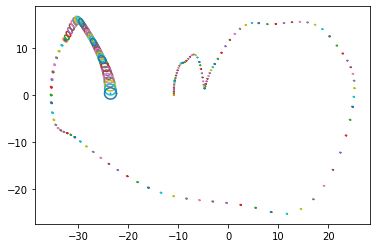

In [9]:
from scipy.interpolate import CubicHermiteSpline
# plot lqr_rho
# sampling points in the epplisolid (x-xG)TS(x-xG)=rho

def plot_ellipsoid(S, rho, x0, alpha=1.0):
    theta = np.linspace(0, np.pi*2, 100)
    U = [np.cos(theta), np.sin(theta), np.zeros(100), np.zeros(100)]
    U = np.array(U).T
    tmp = np.linalg.pinv(S)
    tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
    S_invsqrt = scipy.linalg.sqrtm(tmp)
    X = U @ S_invsqrt  # 100x2
    X = np.sqrt(rho)*X + x0
    plt.plot(X[:,0],X[:,1], alpha=alpha)

plot_ellipsoid(lqr_S, lqr_rho, xG)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    #rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    #rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        #rho_t = rho_cubic(plot_t)
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t)



t0:
0.0
0-th sample
num: 526
1-th sample
num: 526
2-th sample
num: 526
3-th sample
num: 526
4-th sample
num: 526
5-th sample
num: 526
6-th sample
num: 526
7-th sample
num: 526
8-th sample
num: 526
9-th sample
num: 526
10.127999999999998
10.173555555555554
10.21911111111111
10.264666666666665
10.31022222222222
10.355777777777776
10.401333333333332
10.446888888888887
10.492444444444443
10.537999999999998
9.947999999999999
9.967999999999998
9.987999999999998
10.008
10.027999999999999
10.047999999999998
10.067999999999998
10.088
10.107999999999999
10.127999999999998
9.753999999999998
9.775555555555554
9.797111111111109
9.818666666666665
9.84022222222222
9.861777777777776
9.883333333333331
9.904888888888888
9.926444444444442
9.947999999999999
9.511999999999999
9.538888888888888
9.565777777777777
9.592666666666664
9.619555555555554
9.646444444444443
9.673333333333332
9.70022222222222
9.727111111111109
9.753999999999998
8.959999999999999
9.021333333333333
9.082666666666666
9.143999999999998
9

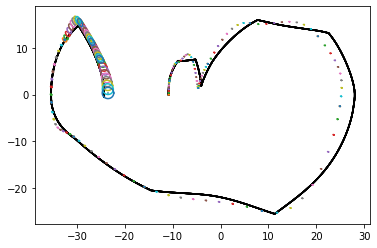

In [10]:

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
#rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[-1]
rho0, rho1, t0, t1 = tvlqr_rhos[-1]

print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 10
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
X0 = np.sqrt(1e-2)*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/0.02
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        actual_x = enforce_bounds(actual_x)
    xs = np.array(xs)
    #print(xs)
    #print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')

plot_ellipsoid(lqr_S, lqr_rho, xG)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    #rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    #rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        #rho_t = rho_cubic(plot_t)
        #rho_t = rho_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t)



In [11]:
def plot_ellipsoid(S, rho, x0, alpha=1.0):
    theta = np.linspace(0, np.pi*2, 100)
    U = [np.cos(theta), np.sin(theta), np.zeros(100), np.zeros(100)]
    U = np.array(U).T
    tmp = np.linalg.pinv(S)
    tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
    S_invsqrt = scipy.linalg.sqrtm(tmp)
    X = U @ S_invsqrt  # 100x2
    X = np.sqrt(rho)*X + x0
    plt.plot(X[:,0],X[:,1], alpha=alpha)


10.127999999999998
10.173555555555554
10.21911111111111
10.264666666666665
10.31022222222222
10.355777777777776
10.401333333333332
10.446888888888887
10.492444444444443
10.537999999999998
9.947999999999999
9.967999999999998
9.987999999999998
10.008
10.027999999999999
10.047999999999998
10.067999999999998
10.088
10.107999999999999
10.127999999999998
9.753999999999998
9.775555555555554
9.797111111111109
9.818666666666665
9.84022222222222
9.861777777777776
9.883333333333331
9.904888888888888
9.926444444444442
9.947999999999999
9.511999999999999
9.538888888888888
9.565777777777777
9.592666666666664
9.619555555555554
9.646444444444443
9.673333333333332
9.70022222222222
9.727111111111109
9.753999999999998
8.959999999999999
9.021333333333333
9.082666666666666
9.143999999999998
9.205333333333332
9.266666666666666
9.328
9.389333333333331
9.450666666666665
9.511999999999999
8.142
8.232888888888889
8.323777777777778
8.414666666666665
8.505555555555555
8.596444444444444
8.687333333333333
8.7782222

[[-1.08930138e+01 -1.22124454e-02 -4.26810212e-01  4.25601995e-02]
 [-1.08932580e+01  4.37214740e-01 -4.25959008e-01 -5.68250715e-02]
 [-1.08845137e+01  8.86880496e-01 -4.27095510e-01 -1.56370178e-01]
 ...
 [-2.42955855e+01 -2.02805141e-01 -1.67962569e+00  3.57728591e-01]
 [-2.42996416e+01 -5.60816730e-01 -1.67247112e+00  4.04987727e-01]
 [-2.43108580e+01 -5.58452348e-01 -1.66437137e+00  4.64147654e-01]]
[[-10.85549272   0.          -0.43466169   0.        ]
 [-10.85324911   0.4645418   -0.43516478  -0.10304246]
 [-10.84569431   0.94822997  -0.43684512  -0.21191287]
 ...
 [-23.53113776   1.06893952  -1.57440428   0.52240362]
 [-23.51306186   0.70625352  -1.56343885   0.58167791]
 [-23.50249012   0.33960499  -1.55120611   0.64251638]]
9-th sample
num: 526
[[-1.08556512e+01 -1.67882602e-04 -4.34612541e-01  2.84511281e-04]
 [-1.08556546e+01  4.48233683e-01 -4.34606850e-01 -9.79541476e-02]
 [-1.08466899e+01  8.96674960e-01 -4.36565933e-01 -1.96204346e-01]
 ...
 [-2.42855609e+01 -2.01968517

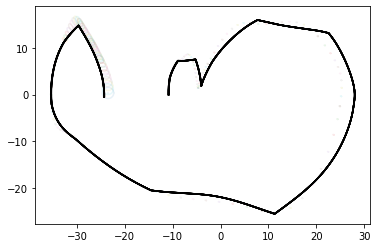

In [12]:

plot_ellipsoid(lqr_S, lqr_rho, xG, alpha=0.1)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    #rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    #rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        #rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        #rho_t = rho_cubic(plot_t)
        rho_t = rho_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t, alpha=0.1)

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
#rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[-1]
rho0, rho1, t0, t1 = tvlqr_rhos[-1]

print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 10
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
rho0 = rho0 * 4.
X0 = np.sqrt(rho0)*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/0.02
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        actual_x = enforce_bounds(actual_x)
    xs = np.array(xs)
    print(xs)
    print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')



10.127999999999998
10.173555555555554
10.21911111111111
10.264666666666665
10.31022222222222
10.355777777777776
10.401333333333332
10.446888888888887
10.492444444444443
10.537999999999998
9.947999999999999
9.967999999999998
9.987999999999998
10.008
10.027999999999999
10.047999999999998
10.067999999999998
10.088
10.107999999999999
10.127999999999998
9.753999999999998
9.775555555555554
9.797111111111109
9.818666666666665
9.84022222222222
9.861777777777776
9.883333333333331
9.904888888888888
9.926444444444442
9.947999999999999
9.511999999999999
9.538888888888888
9.565777777777777
9.592666666666664
9.619555555555554
9.646444444444443
9.673333333333332
9.70022222222222
9.727111111111109
9.753999999999998
8.959999999999999
9.021333333333333
9.082666666666666
9.143999999999998
9.205333333333332
9.266666666666666
9.328
9.389333333333331
9.450666666666665
9.511999999999999
8.142
8.232888888888889
8.323777777777778
8.414666666666665
8.505555555555555
8.596444444444444
8.687333333333333
8.7782222

[[-10.82412431   0.15864651  -0.47330544  -0.19997231]
 [-10.82095138   0.60077874  -0.47730489  -0.29214936]
 [-10.8089358    1.0420028   -0.48314788  -0.38362553]
 ...
 [-24.14812267  -0.20332972  -1.69391339   0.3259766 ]
 [-24.15218927  -0.5605849   -1.68739385   0.37162606]
 [-24.16340096  -0.55706028  -1.67996133   0.43074098]]
[[-10.85549272   0.          -0.43466169   0.        ]
 [-10.85324911   0.4645418   -0.43516478  -0.10304246]
 [-10.84569431   0.94822997  -0.43684512  -0.21191287]
 ...
 [-23.53113776   1.06893952  -1.57440428   0.52240362]
 [-23.51306186   0.70625352  -1.56343885   0.58167791]
 [-23.50249012   0.33960499  -1.55120611   0.64251638]]
9-th sample
num: 526
[[-10.74205056   0.12004351  -0.47921372  -0.18252528]
 [-10.73964969   0.56153505  -0.48286423  -0.27385527]
 [-10.72841899   1.00220713  -0.48834133  -0.36454712]
 ...
 [-24.18939509  -0.19058321  -1.65717525   0.40759055]
 [-24.19320675  -0.54993304  -1.64902344   0.45736861]
 [-24.20420541  -0.54947305

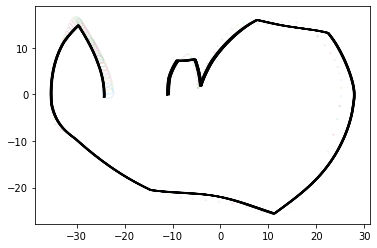

In [13]:

plot_ellipsoid(lqr_S, lqr_rho, xG, alpha=0.1)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    #rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    #rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        #rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        #rho_t = rho_cubic(plot_t)
        rho_t = rho_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t, alpha=0.1)

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
#rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[-1]
rho0, rho1, t0, t1 = tvlqr_rhos[-1]

print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 10
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
rho0 = rho0 * 64.
X0 = np.sqrt(rho0)*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/0.02
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        actual_x = enforce_bounds(actual_x)
    xs = np.array(xs)
    print(xs)
    print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')



10.127999999999998
10.173555555555554
10.21911111111111
10.264666666666665
10.31022222222222
10.355777777777776
10.401333333333332
10.446888888888887
10.492444444444443
10.537999999999998
9.947999999999999
9.967999999999998
9.987999999999998
10.008
10.027999999999999
10.047999999999998
10.067999999999998
10.088
10.107999999999999
10.127999999999998
9.753999999999998
9.775555555555554
9.797111111111109
9.818666666666665
9.84022222222222
9.861777777777776
9.883333333333331
9.904888888888888
9.926444444444442
9.947999999999999
9.511999999999999
9.538888888888888
9.565777777777777
9.592666666666664
9.619555555555554
9.646444444444443
9.673333333333332
9.70022222222222
9.727111111111109
9.753999999999998
8.959999999999999
9.021333333333333
9.082666666666666
9.143999999999998
9.205333333333332
9.266666666666666
9.328
9.389333333333331
9.450666666666665
9.511999999999999
8.142
8.232888888888889
8.323777777777778
8.414666666666665
8.505555555555555
8.596444444444444
8.687333333333333
8.7782222

[[-1.11986506e+01 -4.97764588e-02 -4.15895175e-01  1.02008725e-01]
 [-1.11996461e+01  4.01626663e-01 -4.13855000e-01  8.76141598e-04]
 [-1.11916136e+01  8.53543472e-01 -4.13837478e-01 -1.00622338e-01]
 ...
 [-2.42964621e+01 -1.74383528e-01 -1.68289052e+00  3.50479039e-01]
 [-2.42999497e+01 -5.32218382e-01 -1.67588094e+00  3.97370748e-01]
 [-2.43105941e+01 -5.29587957e-01 -1.66793353e+00  4.56520661e-01]]
[[-10.85549272   0.          -0.43466169   0.        ]
 [-10.85324911   0.4645418   -0.43516478  -0.10304246]
 [-10.84569431   0.94822997  -0.43684512  -0.21191287]
 ...
 [-23.53113776   1.06893952  -1.57440428   0.52240362]
 [-23.51306186   0.70625352  -1.56343885   0.58167791]
 [-23.50249012   0.33960499  -1.55120611   0.64251638]]
9-th sample
num: 526
[[-10.57965108   0.37398005  -0.43741868  -0.56218844]
 [-10.57217147   0.8182865   -0.44866245  -0.65899088]
 [-10.55580574   1.2598836   -0.46184227  -0.75380126]
 ...
 [-23.78544047  -0.50443048  -1.93608345  -0.22139221]
 [-23.7955

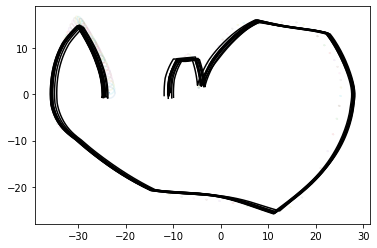

In [14]:

plot_ellipsoid(lqr_S, lqr_rho, xG, alpha=0.4)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    #rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    #rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        #rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        #rho_t = rho_cubic(plot_t)
        rho_t = rho_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t, alpha=0.1)

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
#rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[-1]
rho0, rho1, t0, t1 = tvlqr_rhos[-1]

print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 10
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
rho0 = rho0 * 625
X0 = np.sqrt(rho0)*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/0.02
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        actual_x = enforce_bounds(actual_x)
    xs = np.array(xs)
    print(xs)
    print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')



In [ ]:

plot_ellipsoid(lqr_S, lqr_rho, xG, alpha=0.4)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    #rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    #rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        #rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        #rho_t = rho_cubic(plot_t)
        rho_t = rho_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t, alpha=0.1)

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
#rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[-1]
rho0, rho1, t0, t1 = tvlqr_rhos[-1]

print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 10
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
rho0 = rho0 * 2500
X0 = np.sqrt(rho0)*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/0.02
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        actual_x = enforce_bounds(actual_x)
    xs = np.array(xs)
    print(xs)
    print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')



10.127999999999998
10.173555555555554
10.21911111111111
10.264666666666665
10.31022222222222
10.355777777777776
10.401333333333332
10.446888888888887
10.492444444444443
10.537999999999998
9.947999999999999
9.967999999999998
9.987999999999998
10.008
10.027999999999999
10.047999999999998
10.067999999999998
10.088
10.107999999999999
10.127999999999998
9.753999999999998
9.775555555555554
9.797111111111109
9.818666666666665
9.84022222222222
9.861777777777776
9.883333333333331
9.904888888888888
9.926444444444442
9.947999999999999
9.511999999999999
9.538888888888888
9.565777777777777
9.592666666666664
9.619555555555554
9.646444444444443
9.673333333333332
9.70022222222222
9.727111111111109
9.753999999999998
8.959999999999999
9.021333333333333
9.082666666666666
9.143999999999998
9.205333333333332
9.266666666666666
9.328
9.389333333333331
9.450666666666665
9.511999999999999
8.142
8.232888888888889
8.323777777777778
8.414666666666665
8.505555555555555
8.596444444444444
8.687333333333333
8.7782222

In [ ]:

plot_ellipsoid(lqr_S, lqr_rho, xG, alpha=0.1)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    #rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    #rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        #rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        #rho_t = rho_cubic(plot_t)
        rho_t = rho_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t, alpha=0.1)

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
#rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[-1]
rho0, rho1, t0, t1 = tvlqr_rhos[-1]

print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 10
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
rho0 = rho0 * 1e4
X0 = np.sqrt(rho0)*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/0.02
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        actual_x = enforce_bounds(actual_x)
    xs = np.array(xs)
    print(xs)
    print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')

